In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import seaborn as sns

In [2]:
ts = "20240205"
df = pd.read_pickle("processed/mbo_%s.pkl" % ts)

Event type distribution:
action
A    1269738
C    1251951
M     556086
F     381322
T     105360
R          1
Name: count, dtype: int64


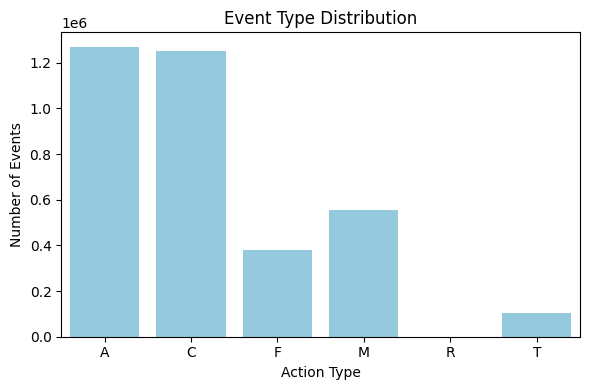

In [30]:
# Action
action_counts = df['action'].value_counts()
print("Event type distribution:")
print(action_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=action_counts.index, y=action_counts.values, color="skyblue")
plt.title("Event Type Distribution")
plt.xlabel("Action Type")
plt.ylabel("Number of Events")
plt.tight_layout()

Side distribution (order events by side):
side
B    1882256
A    1674627
N       7575
Name: count, dtype: int64


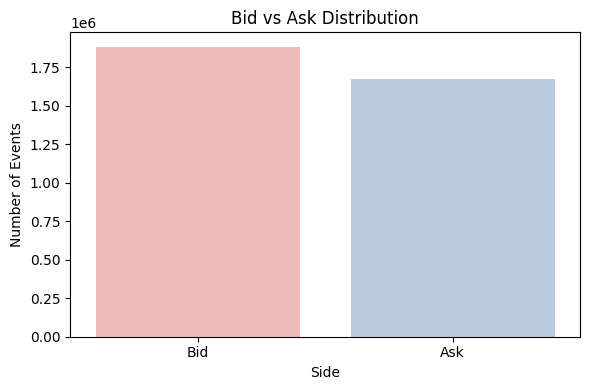

In [31]:
# Side
side_counts = df['side'].value_counts()
bid_count = side_counts.get('B')
ask_count = side_counts.get('A')
print("Side distribution (order events by side):")
print(side_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=["Bid", "Ask"], y=[bid_count, ask_count], palette="Pastel1")
plt.title("Bid vs Ask Distribution")
plt.xlabel("Side")
plt.ylabel("Number of Events")
plt.tight_layout()


count    1.269738e+06
mean     1.585362e+01
std      6.243953e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      1.000000e+01
max      5.261000e+03
Name: size, dtype: float64


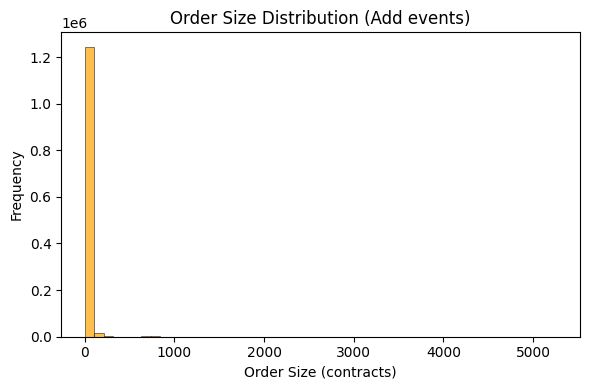

In [33]:
# Size of order
add_sizes = df[df['action'].isin(['A'])]['size']
print(add_sizes.describe())

plt.figure(figsize=(6,4))
plt.hist(add_sizes, bins=50, color="orange", alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title("Order Size Distribution (Add events)")
plt.xlabel("Order Size (contracts)")
plt.ylabel("Frequency")
plt.tight_layout()

Peak activity: 41088 events in 1 minute at 2024-02-05 10:00:00-05:00


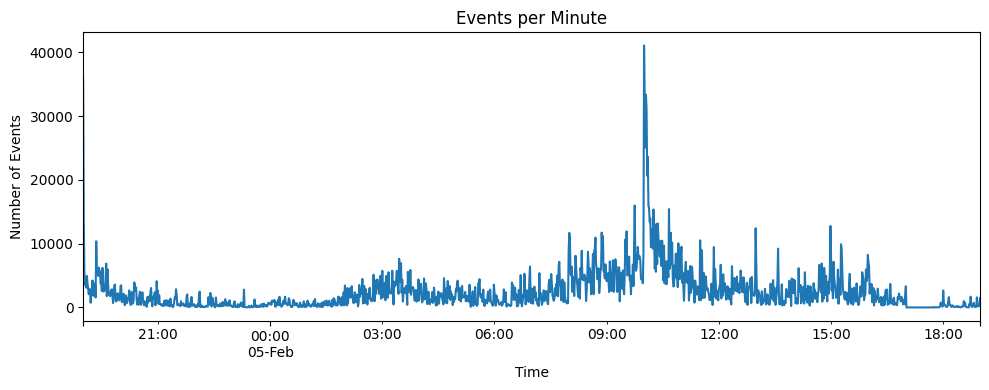

In [40]:
df = df.sort_values('ts_recv') 

events_per_min = df.set_index('ts_recv')['action'].resample('T').count() # minute frequency

# peak activity
peak_minute = events_per_min.idxmax()
peak_count = events_per_min.max()
print(f"Peak activity: {peak_count} events in 1 minute at {peak_minute}")

plt.figure(figsize=(10,4))
events_per_min.plot()
plt.title("Events per Minute")
plt.xlabel("Time")
plt.ylabel("Number of Events")
plt.tight_layout()


Price range: 0.015625 to 6779.156250


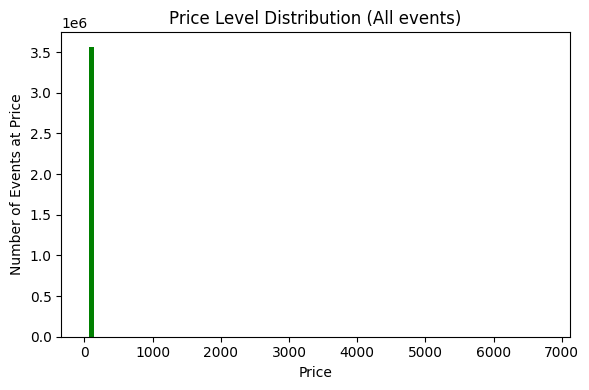

In [41]:
# Price level distribution: price level & changes over time.
min_price = df['price'].min()
max_price = df['price'].max()
print(f"Price range: {min_price:.6f} to {max_price:.6f}")

plt.figure(figsize=(6,4))
plt.hist(df['price'], bins=100, color="green")
plt.title("Price Level Distribution (All events)")
plt.xlabel("Price")
plt.ylabel("Number of Events at Price")
plt.tight_layout()

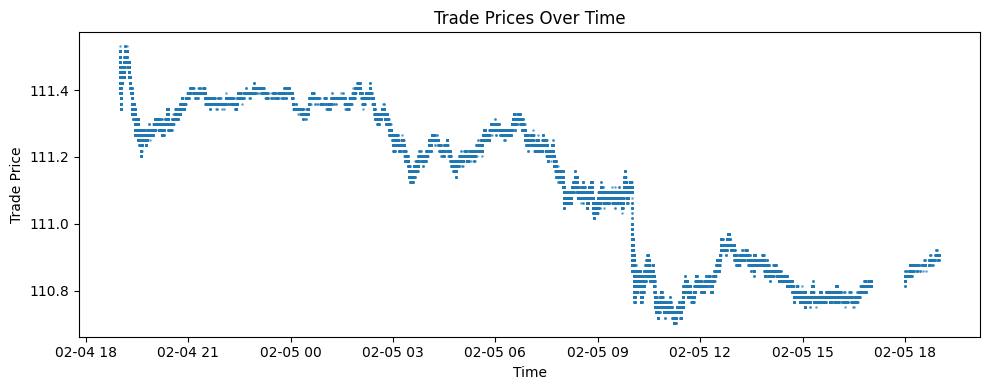

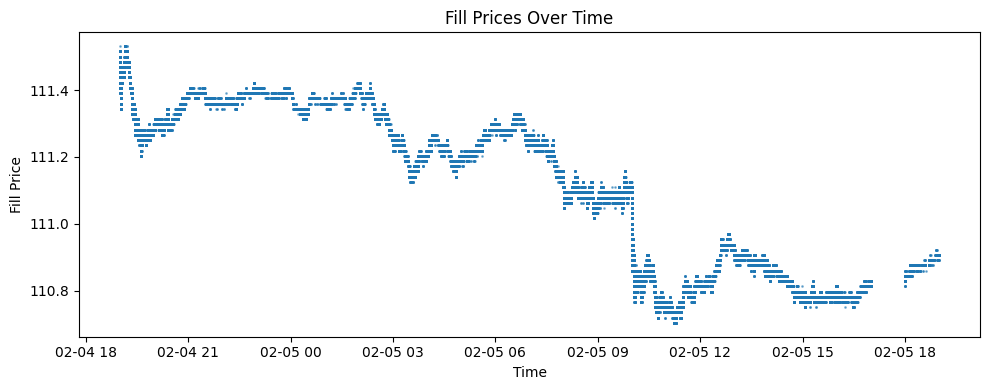

In [44]:
# Trade prices over time
trades = df[df['action'] == 'T']
plt.figure(figsize=(10,4))
plt.plot(trades['ts_recv'], trades['price'], '.', markersize=2, alpha=0.5)
plt.title("Trade Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Trade Price")
plt.tight_layout()

fills = df[df['action'] == 'F']
plt.figure(figsize=(10,4))
plt.plot(fills['ts_recv'], fills['price'], '.', markersize=2, alpha=0.5)
plt.title("Fill Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Fill Price")
plt.tight_layout()

Order Lifecycle Summary:
Total unique orders: 1359662
Average order duration: 550487.00 ms
Median order duration: 1008.02 ms

Final action distribution:
  C: 1233420
  T: 90450
  F: 17807
  A: 16204
  M: 1781


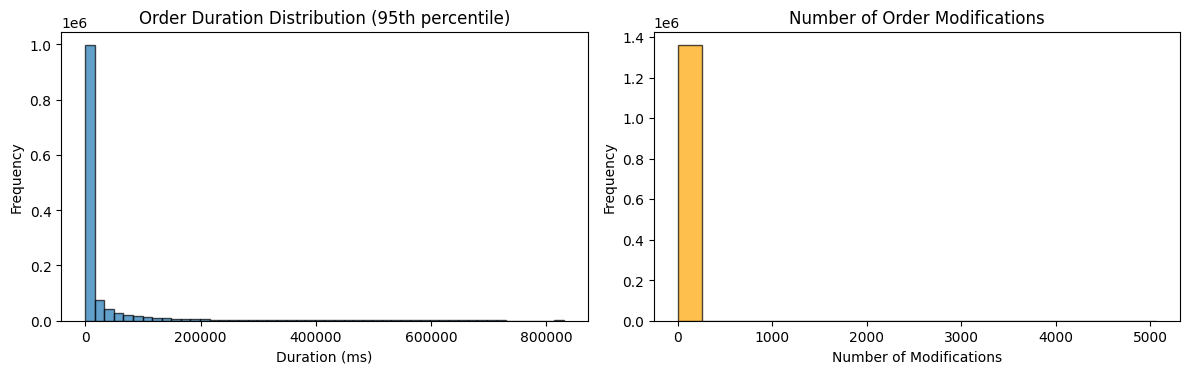

In [ ]:
order_lifecycle = df.groupby('order_id').agg({
    'action': lambda x: list(x),
    'ts_recv': ['min', 'max'],
    'size': 'first',
    'price': 'first',
    'side': 'first'
}).reset_index()

order_lifecycle.columns = ['order_id', 'actions', 'start_time', 'end_time', 'size', 'price', 'side']

order_lifecycle['start_time'] = pd.to_numeric(order_lifecycle['start_time'], errors='coerce')
order_lifecycle['end_time'] = pd.to_numeric(order_lifecycle['end_time'], errors='coerce')
order_lifecycle['duration_ms'] = (order_lifecycle['end_time'] - order_lifecycle['start_time']) / 1e6

order_lifecycle['final_action'] = order_lifecycle['actions'].apply(lambda x: x[-1])
order_lifecycle['num_modifications'] = order_lifecycle['actions'].apply(len) - 1

print("Order Lifecycle Summary:")
print(f"Total unique orders: {len(order_lifecycle)}")
print(f"Average order duration: {order_lifecycle['duration_ms'].mean():.2f} ms")
print(f"Median order duration: {order_lifecycle['duration_ms'].median():.2f} ms")

print("\nFinal action distribution:")
final_action_counts = order_lifecycle['final_action'].value_counts()
for action, count in final_action_counts.items():
    print(f"  {action}: {count}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
duration_filtered = order_lifecycle[order_lifecycle['duration_ms'] < order_lifecycle['duration_ms'].quantile(0.95)]
plt.hist(duration_filtered['duration_ms'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Order Duration Distribution (95th percentile)')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(order_lifecycle['num_modifications'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Number of Order Modifications')
plt.xlabel('Number of Modifications')
plt.ylabel('Frequency')

plt.tight_layout()

Hourly Trading Statistics:
         size        volume  event_count
hour                                    
0      573502  6.393708e+07        34253
1      712616  7.929986e+07        38757
2     2049142  2.282773e+08       127535
3     3327368  3.701940e+08       188508
4     1723943  1.918017e+08       109621
5     2031947  2.259689e+08       101367
6     1486315  1.654079e+08        90196
7     2313641  2.574884e+08       141302
8     4820630  5.359072e+08       331542
9     4787910  5.318733e+08       335311
10    8759651  9.710562e+08       653536
11    3490254  3.865449e+08       221366
12    3107599  3.444243e+08       188911
13    1842674  2.041907e+08       116950
14    2923041  3.237747e+08       161964
15    3297719  3.652605e+08       180635
16    1785784  1.976088e+08        95365
17      83424  9.250786e+06         5193
18     450810  4.987270e+07        21876
19    4731942  5.276149e+08       238232
20    1656649  1.843888e+08        91073
21     774655  8.625980e+07   

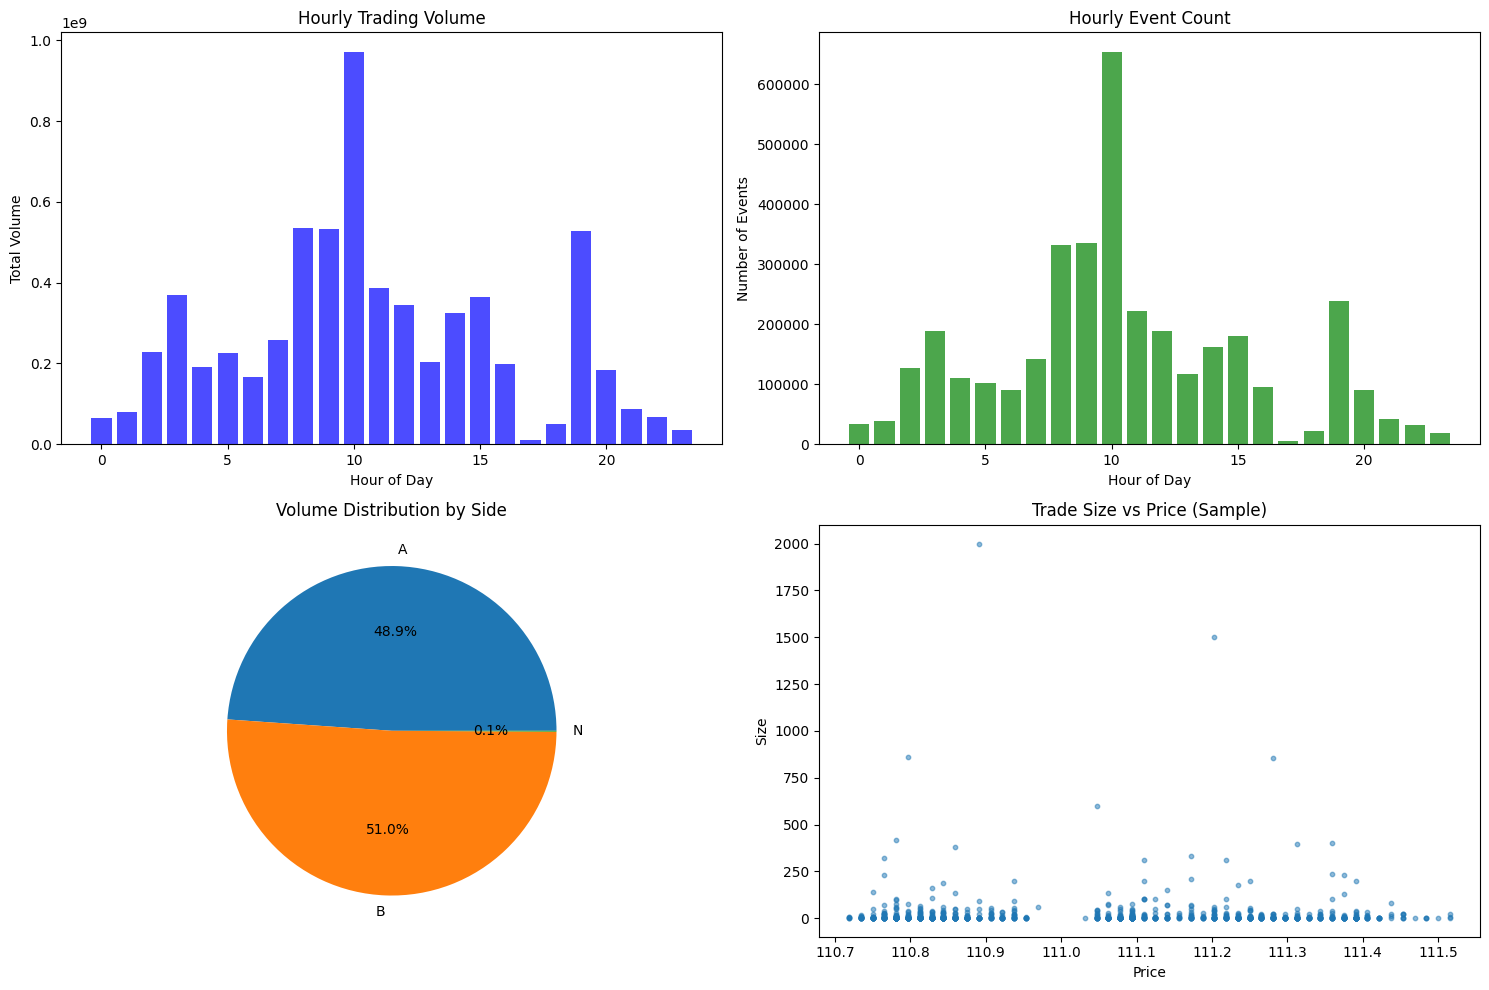

In [ ]:
# Volume analysis over time
df['volume'] = df['size'] * df['price']  # Calculate notional volume

df['hour'] = df['ts_recv'].dt.hour
hourly_volume = df.groupby('hour').agg({
    'size': 'sum',
    'volume': 'sum',
    'action': 'count'
}).rename(columns={'action': 'event_count'})

print("Hourly Trading Statistics:")
print(hourly_volume)

# Volume by action type
volume_by_action = df.groupby('action').agg({
    'size': ['sum', 'mean', 'std'],
    'volume': ['sum', 'mean']}).round(2)

print("\nVolume by Action Type:")
print(volume_by_action)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hourly volume pattern
axes[0,0].bar(hourly_volume.index, hourly_volume['volume'], alpha=0.7, color='blue')
axes[0,0].set_title('Hourly Trading Volume')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Total Volume')

# Hourly event count
axes[0,1].bar(hourly_volume.index, hourly_volume['event_count'], alpha=0.7, color='green')
axes[0,1].set_title('Hourly Event Count')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Number of Events')

# Volume distribution by side
volume_by_side = df.groupby('side')['volume'].sum()
axes[1,0].pie(volume_by_side.values, labels=volume_by_side.index, autopct='%1.1f%%')
axes[1,0].set_title('Volume Distribution by Side')

# Size vs Price scatter
sample_trades = df[df['action'] == 'T'].sample(min(1000, len(df[df['action'] == 'T'])))
axes[1,1].scatter(sample_trades['price'], sample_trades['size'], alpha=0.5, s=10)
axes[1,1].set_title('Trade Size vs Price (Sample)')
axes[1,1].set_xlabel('Price')
axes[1,1].set_ylabel('Size')

plt.tight_layout()

Correlation Matrix:
            price   size  action_num  side_num   hour  minute
price       1.000  0.002       0.000    -0.027 -0.009   0.001
size        0.002  1.000       0.013    -0.007  0.012   0.001
action_num  0.000  0.013       1.000    -0.010  0.008   0.016
side_num   -0.027 -0.007      -0.010     1.000  0.003   0.012
hour       -0.009  0.012       0.008     0.003  1.000  -0.067
minute      0.001  0.001       0.016     0.012 -0.067   1.000


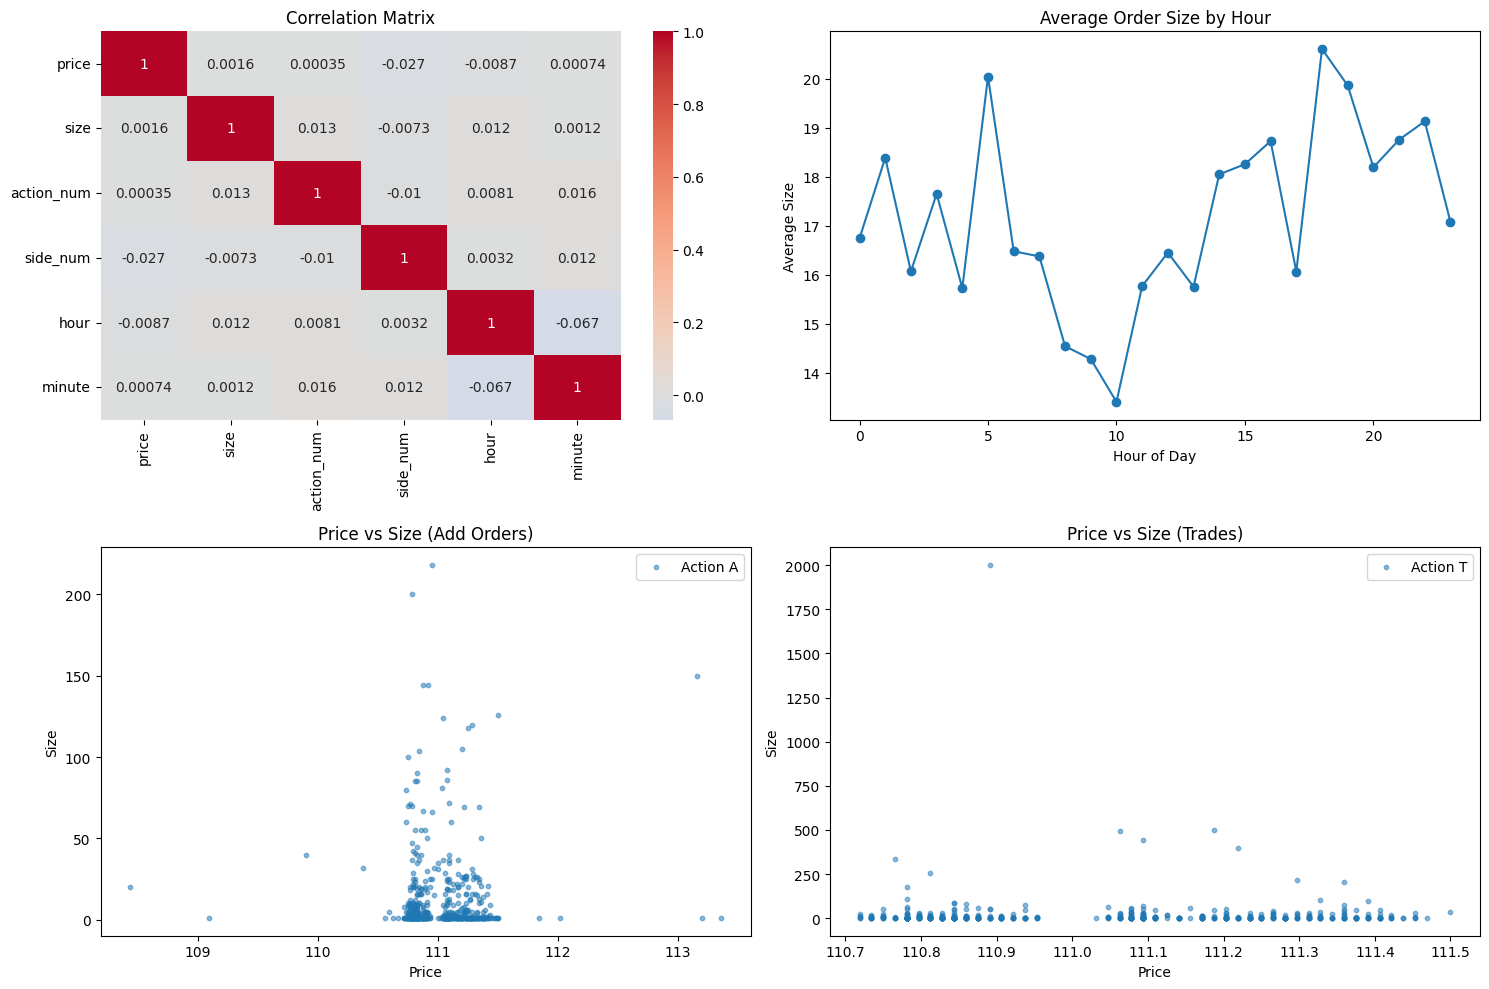

In [51]:
# Create features for correlation analysis
correlation_df = df.copy()

# Add time-based features
correlation_df['minute'] = correlation_df['ts_recv'].dt.minute
correlation_df['second'] = correlation_df['ts_recv'].dt.second

# Create numerical encoding for categorical variables
action_mapping = {'A': 1, 'C': 2, 'M': 3, 'F': 4, 'T': 5}
side_mapping = {'B': 1, 'A': -1}

correlation_df['action_num'] = correlation_df['action'].map(action_mapping)
correlation_df['side_num'] = correlation_df['side'].map(side_mapping)

# Select numerical columns for correlation
numerical_cols = ['price', 'size', 'action_num', 'side_num', 'hour', 'minute']
corr_data = correlation_df[numerical_cols].corr()

print("Correlation Matrix:")
print(corr_data.round(3))

# Analyze size vs price relationship by action type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Correlation heatmap
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Correlation Matrix')

# Size vs Hour relationship
hourly_size = df.groupby('hour')['size'].mean()
axes[0,1].plot(hourly_size.index, hourly_size.values, marker='o')
axes[0,1].set_title('Average Order Size by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Size')

# Price vs Size scatter by action type
for i, action in enumerate(['A', 'T']):
    sample_data = df[df['action'] == action].sample(min(500, len(df[df['action'] == action])))
    if i == 0:
        axes[1,0].scatter(sample_data['price'], sample_data['size'], alpha=0.5, label=f'Action {action}', s=10)
    else:
        axes[1,1].scatter(sample_data['price'], sample_data['size'], alpha=0.5, label=f'Action {action}', s=10)

axes[1,0].set_title('Price vs Size (Add Orders)')
axes[1,0].set_xlabel('Price')
axes[1,0].set_ylabel('Size')
axes[1,0].legend()

axes[1,1].set_title('Price vs Size (Trades)')
axes[1,1].set_xlabel('Price')
axes[1,1].set_ylabel('Size')
axes[1,1].legend()

plt.tight_layout()